# Conditional Generative Adversarial Network
Most of codes reuse from GAN on MNIST

## Import libraries

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import torch
from torchvision import datasets
import torchvision.transforms as transforms

## Load MNIST dataset

In [28]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=int(batch_size/2), num_workers=num_workers)

### Visualize the sample data

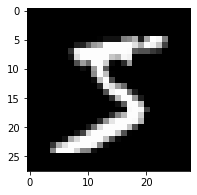

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Define cGAN

### Scale function to change scale fo dataset

In [4]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = x * (feature_range[1] - feature_range[0]) + feature_range[0]
    return x

## Define Discriminator and Generator
The simple GAN suffers from a serious problem. It is generating images **unconditionally** i.e we have no control over the output our model is generating. To overcome this limitation, conditional GANs were invented. The architecture of C-GANs is same as normal GANs but this time the model takes in **some metadata as input** along with the random noise and conditions the output on that.

In this notebook, we will pass the digit value as metadata and constrain the cGAN model to generate an image of the input digit value.

reference websites: 
- https://medium.com/analytics-vidhya/step-by-step-implementation-of-conditional-generative-adversarial-networks-54e4b47497d6
- https://blog.naver.com/laonple/221306150417

#### Changing points

In the Discriminator and the Generator, we add a new embedding layer. This layer makes the metadata(label) convert to 10-dimensional tensor. And the next layer(previous first layer)'s input size is increased(_original input size + 10(label dimension)_)

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # For metadata, add embedding layer
        self.label_embedding = nn.Embedding(10, 10)
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):       
        # flatten image
        x = x.view(-1, 28*28)
        
        # pass x through all layers
        # apply leaky relu activation to all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.1)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.1)
        x = self.dropout(x)
        x = self.fc4(x)

        return x

class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # For label, add embedding layer
        self.label_embedding = nn.Embedding(10, 10)
        
        # define all layers
        self.fc1 = nn.Linear(input_size + 10, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        self.dropout = nn.Dropout(0.3)        

    def forward(self, x, labels):
        c = self.label_embedding(labels)
        x = torch.cat([x, c], 1)
        
        # pass x through all layers
        x = F.leaky_relu(self.fc1(x), 0.1)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.1)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.1)
        x = self.dropout(x)
        x = self.fc4(x)        
        # final layer should have tanh applied
        x = torch.tanh(x)
        
        return x

### Hyperparameters

In [6]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 11
# Size of *last* hidden layer in the discriminator
d_hidden_size = 256

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of *first* hidden layer in the generator
g_hidden_size = 256

### Initialized Discriminator and Generator

In [7]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (label_embedding): Embedding(10, 10)
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=11, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (label_embedding): Embedding(10, 10)
  (fc1): Linear(in_features=110, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


### Loss functions
Use two different loss functions for real data and fake data. At the end, we add these two loss and optimize

In [8]:
# Calculate losses
def real_loss(D_out, labels, smooth=False):
    # compare logits to real labels
    # smooth labels if smooth=True
    criterion = nn.CrossEntropyLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    # compare logits to fake labels
    batch_size = D_out.size(0)
    
    labels = torch.ones(batch_size, dtype=int) * 10
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.CrossEntropyLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

### Optimizer
Use Adam optimizer for each module(discriminator & generator)

In [9]:
import torch.optim as optim

# learning rate for optimizers
lr = 0.0002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

### Training on GPU

Check if you can train on GPU. If you can, set this as a variable and move your models to GPU. 

In [10]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')

GPU available for training. Models moved to GPU


## Training
To train the model, we need to feed label(metadata). If input data is real images, we have to feed real labels. if input data is fake images, we have to feed fake labels which used to generate fake images.

In [11]:
import pickle as pkl

# training hyperparams
num_epochs = 100

# keep track of loss and generated, "fake" samples
samples = []
sample_labels = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_l = torch.randint(0, 10, (sample_size,))

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, real_labels) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = scale(real_images)  # rescale input images from [0,1) to [-1, 1)
        if train_on_gpu:
            real_images = real_images.cuda()
            real_labels = real_labels.cuda()
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
                
        # 1. Train with real images
        real_out = D(real_images)
        real_losses = real_loss(real_out, real_labels, True)

        # Compute the discriminator losses on real images
        # use smoothed labels
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_labels = torch.randint(0, 10, (batch_size,))
        
        if train_on_gpu:
            z = z.cuda()
            fake_labels = fake_labels.cuda()
            
        fake_images = G(z, fake_labels)
        
        # Compute the discriminator losses on fake images        
        fake_out = D(fake_images)
        fake_losses = fake_loss(fake_out)
        
        # add up real and fake losses and perform backprop
        d_loss = real_losses + fake_losses
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        
        g_optimizer.zero_grad()
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        
        # Fake labels
        fake_labels = torch.randint(0, 10, (batch_size,))
        
        if train_on_gpu:
            z = z.cuda()
            fake_labels = fake_labels.cuda()
            
        fake_images = G(z, fake_labels)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        g_out = D(fake_images)
        
        # perform backprop
        g_loss = real_loss(g_out, fake_labels)
        g_loss.backward()
        g_optimizer.step()        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
        fixed_l = fixed_l.cuda()
        
    samples_z = G(fixed_z, fixed_l)
    samples.append(samples_z)
    sample_labels.append(fixed_l)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples_cgan_mc.pkl', 'wb') as f:
    pkl.dump(samples, f)
    
with open('train_samples_cgan_mc_label.pkl', 'wb') as f:
    pkl.dump(sample_labels, f)    

Epoch [    1/  100] | d_loss: 4.8825 | g_loss: 2.3854
Epoch [    1/  100] | d_loss: 1.1872 | g_loss: 3.4050
Epoch [    1/  100] | d_loss: 1.4750 | g_loss: 4.0261
Epoch [    2/  100] | d_loss: 0.9337 | g_loss: 3.1089
Epoch [    2/  100] | d_loss: 1.1293 | g_loss: 2.3109
Epoch [    2/  100] | d_loss: 0.6820 | g_loss: 5.2815
Epoch [    3/  100] | d_loss: 0.6737 | g_loss: 4.1269
Epoch [    3/  100] | d_loss: 0.6337 | g_loss: 4.8320
Epoch [    3/  100] | d_loss: 0.5329 | g_loss: 3.4914
Epoch [    4/  100] | d_loss: 0.7012 | g_loss: 4.7684
Epoch [    4/  100] | d_loss: 0.7001 | g_loss: 4.7342
Epoch [    4/  100] | d_loss: 0.7061 | g_loss: 4.2307
Epoch [    5/  100] | d_loss: 0.4477 | g_loss: 6.0344
Epoch [    5/  100] | d_loss: 0.8397 | g_loss: 4.6362
Epoch [    5/  100] | d_loss: 0.3260 | g_loss: 4.5278
Epoch [    6/  100] | d_loss: 0.4174 | g_loss: 3.5902
Epoch [    6/  100] | d_loss: 0.6409 | g_loss: 2.7350
Epoch [    6/  100] | d_loss: 0.5704 | g_loss: 3.2260
Epoch [    7/  100] | d_loss

## Evaluation

### Trend of losses

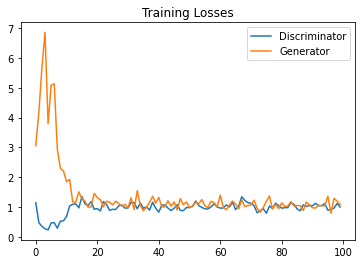

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

### Visualize generated sample images

In [13]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples, sample_labels):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for idx, (ax, img) in enumerate(zip(axes.flatten(), samples[epoch])):
        img = img.detach()
        if train_on_gpu:
            img = img.cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.set_title(sample_labels[epoch][idx].item())
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [14]:
# Load samples from generator, taken while training
with open('train_samples_cgan_mc.pkl', 'rb') as f:
    samples = pkl.load(f)
    
with open('train_samples_cgan_mc_label.pkl', 'rb') as f:
    sample_labels = pkl.load(f)    

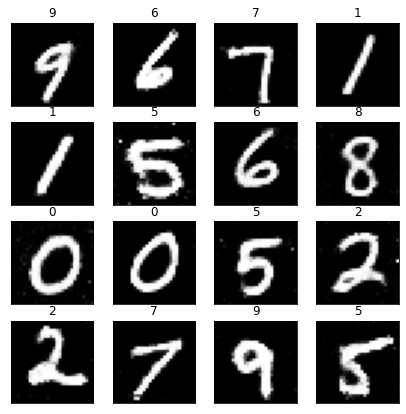

In [15]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples, sample_labels)

In [57]:
z_size = 100

outputs = []

D.eval()
G.eval()

for real_images, real_labels in test_loader:
    batch_size = real_images.size(0)
    real_images = scale(real_images)
           
    meta_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    meta_z = torch.from_numpy(meta_z).float()
    fake_labels = torch.randint(0, 10, (batch_size,))
    
    if train_on_gpu:
        real_images, real_labels = real_images.cuda(), real_labels.cuda()
        meta_z, fake_labels = meta_z.cuda(), fake_labels.cuda()
    
    fake_images = G(meta_z, fake_labels)
    images = torch.cat([real_images.view(-1, 28*28), fake_images])
    labels = torch.cat([real_labels, fake_labels])
    
    out = torch.argmax(D(images), dim=1)
    
    outputs.append({'images': images, 'labels': labels, 'outputs': out})

In [59]:
outputs[0]

{'images': tensor([[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         ...,
         [-0.9956, -1.0000, -1.0000,  ..., -1.0000, -0.9998, -0.9993],
         [-0.9976, -1.0000, -0.9993,  ..., -0.9982, -0.9948, -0.9885],
         [-0.9939, -0.8185, -0.9896,  ..., -0.9944, -0.9965, -0.9987]],
        device='cuda:0', grad_fn=<CatBackward>),
 'labels': tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
         4, 0, 7, 4, 0, 1, 3, 1, 6, 3, 2, 9, 9, 6, 5, 1, 1, 0, 1, 1, 7, 1, 8, 9,
         6, 9, 6, 0, 7, 4, 0, 5, 8, 4, 9, 1, 0, 2, 2, 5], device='cuda:0'),
 'outputs': tensor([10,  2, 10, 10, 10, 10, 10,  9,  5, 10, 10,  6, 10, 10, 10,  5,  9,  7,
          3, 10, 10, 10,  6,  5, 10, 10, 10,  4, 10, 10, 10, 10, 10, 10,  2, 10,
         10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  4

In [61]:
samples[-1].shape

torch.Size([16, 784])

In [60]:
outputs[0]['images']

torch.Size([64, 784])

In [73]:
# helper function for viewing a list of passed in sample images
def view_output_results(output):
    fig, axes = plt.subplots(figsize=(14,14), nrows=8, ncols=8, sharey=True, sharex=True)
    for idx, (ax, img) in enumerate(zip(axes.flatten(), output['images'])):
        img = img.detach()
        if train_on_gpu:
            img = img.cpu()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        
        actl_label = output['labels'][idx].item()
        pred_label = output['outputs'][idx].item()
        actl_label = '%d(fake)' % actl_label if idx >= 32 else '%d(real)' % actl_label
        pred_label = 'fake' if pred_label == 10 else '%d' % pred_label
        ax.set_title('%s vs. %s' % (actl_label, pred_label))
        
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

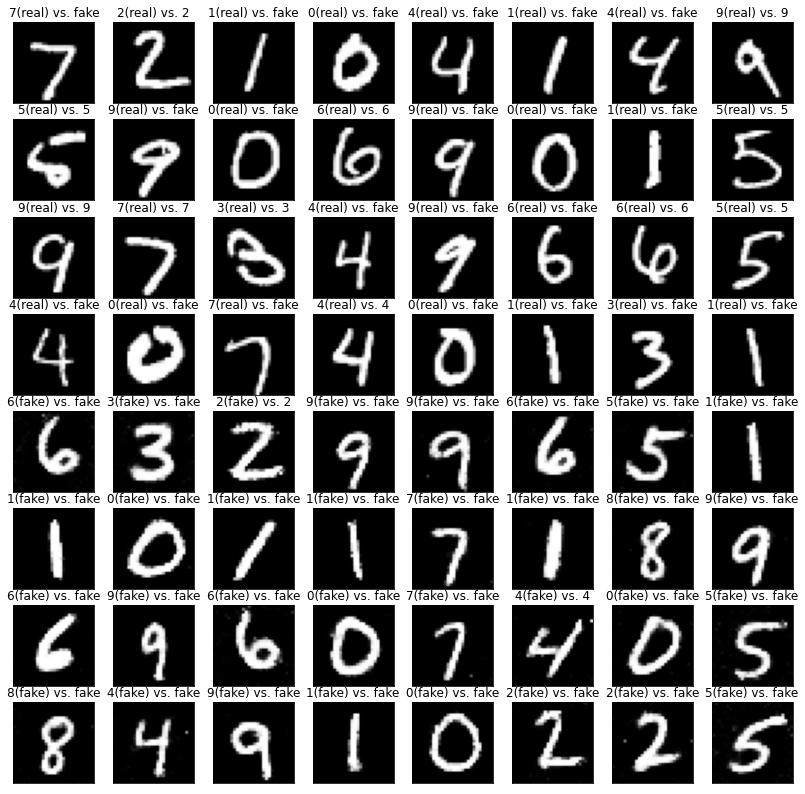

In [74]:
view_output_results(outputs[0])